In [1]:
import xarray as xr
import xesmf
import matplotlib.pyplot as plt
import bottleneck
import numpy as np
import subprocess as sp
import os
import glob
import cartopy.crs as ccrs

# Create OBC files using MOM6-based boundary conditions

This example uses monthly output from an OM4_025-based simulation in order to generate
boundary conditions for a Pan-Arctic configuration. Ocean current vectors from a staggered
C-grid are co-located at q-points (corners). The grid rotation angles contained in the 
MOM6 supergrid files are used to align the currents with the target regional grid.

### Required files
    * Parent model supergrid file
    * Region model supergrid file and bathymetry
    * Parent model data

### Step 1: Open parent and regional model grids

In [2]:
def open_grid(path,decode_times=False):
    """Return a grid object containing staggered grid locations"""
    grid={}
    grid['ds']=xr.open_dataset(path,decode_times=False)
    grid['ds']=grid['ds'].drop_dims(['ny','nx'])
    grid['ds']=grid['ds'].drop_vars(['tile'])
    grid['nyp']=grid['ds'].nyp.data[-1]+1
    grid['nxp']=grid['ds'].nxp.data[-1]+1
    nxp=grid['nxp'];nyp=grid['nyp']
    grid['h'] = grid['ds'].isel(nxp=slice(1,nxp+1,2),nyp=slice(1,nyp+1,2))
    #The q grid is not symmetric, but Cu and Cv are
    grid['q'] = grid['ds'].isel(nxp=slice(2,nxp+1,2),nyp=slice(2,nyp+1,2))
    grid['Cu'] = grid['ds'].isel(nxp=slice(0,nxp+1,2),nyp=slice(1,nyp+1,2))
    grid['Cv'] = grid['ds'].isel(nxp=slice(1,nxp+1,2),nyp=slice(0,nyp+1,2))
    return grid

In [3]:
#Note that parent grid uv values are symmetric
path_parent_grid='/net2/mjh/ipynb/OM4_025/c192_mosaic/ocean_hgrid.nc'
parent_grid=open_grid(path_parent_grid)
path_regional_grid='./ocean_hgrid.nc'
regional_grid=open_grid(path_regional_grid)

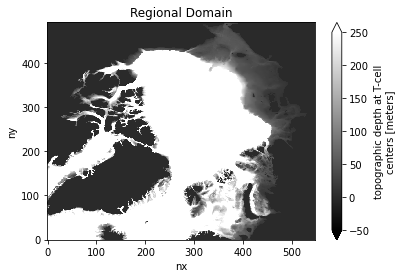

In [45]:
dsr_topo=xr.open_dataset('topog.nc')
dsr_topo = xr.merge([dsr_topo, regional_grid['h']])
dsr_topo.depth.plot(vmax=-50.,vmin=250.,cmap='gist_gray')
txt=plt.title('Regional Domain')

### Step 2: Open parent model data and merge respective grids

In [4]:
def open_dataset(path,fields,grid):
    ds=xr.open_dataset(path,decode_times=False)
    
    tracer_list=[];uv_list=[]
    for f in fields:
        for fnam,val in zip(f.keys(),f.values()):
            if val=='h':tracer_list.append(fnam)
            if val=='Cu':uv_list.append(fnam)
            if val=='Cv':uv_list.append(fnam)
                
    ds_tr = xr.merge([ds, grid['h']])
    ds_u= xr.merge([ds,grid['Cu']])
    ds_v= xr.merge([ds,grid['Cv']])
    return {'ds_tr':ds_tr,'ds_u':ds_u,'ds_v':ds_v,'tracers':tracer_list,'uv':uv_list}

In [5]:
path_model_data='../data/20120101.ocean_month.nc'
fields=[{'temp':'h'},{'salt':'h'},{'ssh':'h'},{'u':'Cu'},{'v':'Cv'}]
model_data = open_dataset(path_model_data,fields,parent_grid)

### Step 3. Remap velocities to q corners

In [6]:
def velocity_at_corners(ds_u,ds_v):
    nxp=ds_u.nxp[-1].data+1;nyp=ds_v.nyp[-1].data+1
    #upper-right q points
    u_q=0.5*(ds_u.u+ds_u.u.roll(roll_coords='yh',yh=-1)).isel(xq=slice(1,nxp))
    #upper-right q points
    v_q=0.5*(ds_v.v+ds_v.v.roll(roll_coords='xh',xh=-1)).isel(yq=slice(1,nyp))
    ds_uvq = xr.Dataset({'u':u_q,'v':v_q},coords={'time':ds_u.time,'lon':parent_grid['q'].x,'lat':parent_grid['q'].y,'angle_dx':parent_grid['q'].angle_dx})
    return ds_uvq

In [7]:

ds_u=model_data['ds_u'];ds_v=model_data['ds_v']
model_data['ds_uv']=velocity_at_corners(ds_u,ds_v)

In [8]:
def apply_rotation(u,v,angle_dx,time_slice=slice(0)):
    """Rotate from model space to easterly coordinates"""
    deg_rad=np.pi/180.    
    
    if time_slice is not None:
        t=u.time.isel(time=time_slice)
    else:
        t=u.time
        
    if time_slice is not None:
        ue=np.cos(angle_dx.data*deg_rad)*u.isel(time=time_slice).data-np.sin(angle_dx.data*deg_rad)*v.isel(time=time_slice).data
        vn=np.sin(angle_dx.data*deg_rad)*u.isel(time=time_slice).data+np.cos(angle_dx.data*deg_rad)*v.isel(time=time_slice).data  
    else:
        ue=np.cos(angle_dx.data*deg_rad)*u.data-np.sin(angle_dx.data*deg_rad)*v.data
        vn=np.sin(angle_dx.data*deg_rad)*u.data+np.cos(angle_dx.data*deg_rad)*v.data  
        
    us=ue.shape
    nyp=us[2];nxp=us[3]
    ue=xr.DataArray(ue,coords={'i':np.arange(1,nxp+1),'j':np.arange(1,nyp+1),'time':t,'z_l':u.z_l},dims=('time','z_l','j','i'))
    vn=xr.DataArray(vn,coords={'i':np.arange(1,nxp+1),'j':np.arange(1,nyp+1),'time':t,'z_l':u.z_l},dims=('time','z_l','j','i'))
        

    return ue,vn


In [9]:
def apply_rotation_transpose(ue,vn,angle_dx,time_slice=slice(0)):
    """Rotate from easterly coordinates to model space"""
    deg_rad=np.pi/180.
    
    if time_slice is not None:
        t=ue.time.isel(time=time_slice)
    else:
        t=ue.time

    if time_slice is not None:
        u=np.cos(angle_dx.data*deg_rad)*ue.isel(time=time_slice).data+np.sin(angle_dx.data*deg_rad)*vn.isel(time=time_slice).data
        v=-np.sin(angle_dx.data*deg_rad)*ue.isel(time=time_slice).data+np.cos(angle_dx.data*deg_rad)*vn.isel(time=time_slice).data
    else:
        u=np.cos(angle_dx.data*deg_rad)*ue.data+np.sin(angle_dx.data*deg_rad)*vn.data
        v=-np.sin(angle_dx.data*deg_rad)*ue.data+np.cos(angle_dx.data*deg_rad)*vn.data
    nyp=u.shape[2]
      
    u=xr.DataArray(u,coords={'i':np.arange(1,nyp+1),'time':t,'z_l':ue.z_l},dims=('time','z_l','i'))
    v=xr.DataArray(v,coords={'i':np.arange(1,nyp+1),'time':t,'z_l':ue.z_l},dims=('time','z_l','i'))


        
    return u,v

In [10]:
ds_uvq=model_data['ds_uv']
uq_rot,vq_rot= apply_rotation(ds_uvq.u,ds_uvq.v,ds_uvq.angle_dx,time_slice=None)
ds_uvq_r = xr.Dataset({'u':uq_rot,'v':vq_rot},coords={'time':ds_uvq.time,'lon':ds_uvq.lon,'lat':ds_uvq.lat})
model_data['ds_uv_r']=ds_uvq_r

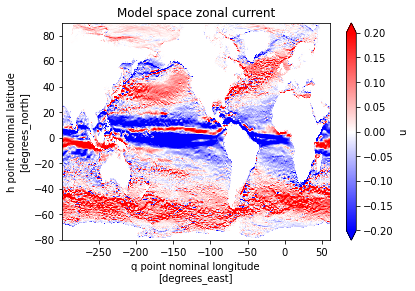

In [11]:
ds_uvq.u.isel(time=0,z_l=0).plot(vmin=-.2,vmax=.2,cmap='bwr')
title=plt.title('Model space zonal current')

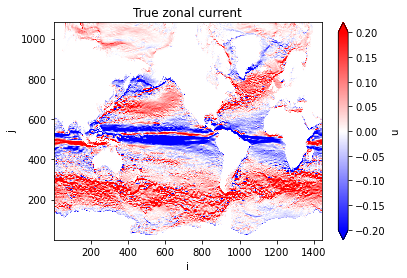

In [12]:
ds_uvq_r.u.isel(time=0,z_l=0).plot(vmin=-.2,vmax=.2,cmap='bwr')
title=plt.title('True zonal current')

In [13]:
def uvmag(u,v,z_slice=0):
    spd=np.sqrt(np.squeeze(u.isel(z_l=z_slice).data**2.0 + v.isel(z_l=z_slice).data**2))
    return xr.DataArray(spd,coords={'i':u.i.data,'j':u.j.data},dims=('j','i'))
    

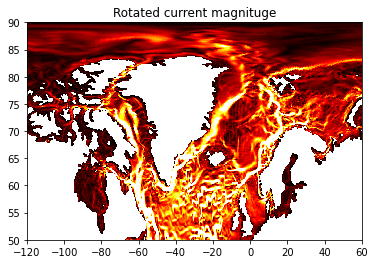

In [14]:
uvmag_r = uvmag(ds_uvq_r.u.isel(time=0),ds_uvq_r.v.isel(time=0))
plt.pcolormesh(parent_grid['q'].x,parent_grid['q'].y,uvmag_r.data,vmin=0.001,vmax=0.2,cmap=plt.cm.hot)
plt.xlim(-120,60)
plt.ylim(50,90)
title=plt.title('Rotated current magnituge')

### Step 4: Define boundaries for regional domain model

In [15]:
ds_regional=regional_grid['ds']
# northern boundary
north = xr.Dataset()
north['lon'] = ds_regional['x'].isel(nyp=-1)
north['lat'] = ds_regional['y'].isel(nyp=-1)
# southern boundary
south = xr.Dataset()
south['lon'] = ds_regional['x'].isel(nyp=0)
south['lat'] = ds_regional['y'].isel(nyp=0)
# western boundary
west = xr.Dataset()
west['lon'] = ds_regional['x'].isel(nxp=0)
west['lat'] = ds_regional['y'].isel(nxp=0)
# eastern boundary
east = xr.Dataset()
east['lon'] = ds_regional['x'].isel(nxp=-1)
east['lat'] = ds_regional['y'].isel(nxp=-1)

In [17]:
#Load tracers
ds_tr=model_data['ds_tr']
ds_tr = xr.Dataset({'temp':ds_tr.temp,'salt':ds_tr.salt},coords={'lon':ds_tr.x,'lat':ds_tr.y})

### Step 5: Calculate remapping weights

In [ ]:
#Using nearest neighbor - other options could be used here , e.g. bilinear.
regrid_north_uv = xesmf.Regridder(ds_uvq_r, north, 'nearest_s2d', 
                               locstream_out=True, periodic=False, filename='regrid_north_uv.nc',reuse_weights=True)
regrid_south_uv = xesmf.Regridder(ds_uvq_r, south, 'nearest_s2d', 
                               locstream_out=True, periodic=False, filename='regrid_south_uv.nc',reuse_weights=True)
regrid_east_uv = xesmf.Regridder(ds_uvq_r, east, 'nearest_s2d', 
                               locstream_out=True, periodic=False, filename='regrid_east_uv.nc',reuse_weights=True)
regrid_west_uv = xesmf.Regridder(ds_uvq_r, west, 'nearest_s2d', 
                               locstream_out=True, periodic=False, filename='regrid_west_uv.nc',reuse_weights=True)

regrid_north_tr = xesmf.Regridder(ds_tr, north, 'nearest_s2d', 
                               locstream_out=True, periodic=False, filename='regrid_north_tr.nc',reuse_weights=True)
regrid_south_tr = xesmf.Regridder(ds_tr, south, 'nearest_s2d', 
                               locstream_out=True, periodic=False, filename='regrid_south_tr.nc',reuse_weights=True)
regrid_west_tr = xesmf.Regridder(ds_tr, west, 'nearest_s2d', 
                               locstream_out=True, periodic=False, filename='regrid_west_tr.nc',reuse_weights=True)

### Step 6: Remap potential temperature,salinity,currents and SSH to boundaries

In [19]:
u_north_r = regrid_north_uv(ds_uvq_r['u'])

In [21]:
v_north_r = regrid_north_uv(ds_uvq_r['v'])
u_south_r = regrid_south_uv(ds_uvq_r['u'])
v_south_r = regrid_south_uv(ds_uvq_r['v'])
u_west_r = regrid_west_uv(ds_uvq_r['u'])
v_west_r = regrid_west_uv(ds_uvq_r['v'])
u_north,v_north=apply_rotation_transpose(u_north_r,v_north_r,ds_regional.angle_dx.isel(nyp=ds_regional.nyp[-1]),time_slice=None)
ds_uv_north = xr.Dataset({'u':u_north,'v':v_north},coords={'lon':north.lon,'lat':north.lat,'z_l':ds_uvq.z_l})
ds_uv_north.time.attrs['calendar']='gregorian'
fnam='uv_north.nc'
ds_uv_north.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')
u_south,v_south=apply_rotation_transpose(u_south_r,v_south_r,ds_regional.angle_dx.isel(nyp=ds_regional.nyp[0]),time_slice=None)
ds_uv_south = xr.Dataset({'u':u_south,'v':v_south},coords={'lon':south.lon,'lat':south.lat,'z_l':ds_uvq.z_l})
fnam='uv_south.nc'
ds_uv_south.time.attrs['calendar']='gregorian'
ds_uv_south.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')
u_west,v_west=apply_rotation_transpose(u_west_r,v_west_r,ds_regional.angle_dx.isel(nxp=ds_regional.nxp[0]),time_slice=None)
ds_uv_west = xr.Dataset({'u':u_west,'v':v_west},coords={'lon':west.lon,'lat':west.lat,'z_l':ds_uvq.z_l})
fnam='uv_west.nc'
ds_uv_west.time.attrs['calendar']='gregorian'
ds_uv_west.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')

In [23]:
temp_north = regrid_north_tr(ds_tr['temp'])
salt_north = regrid_north_tr(ds_tr['salt'])
ds_tr_north = xr.Dataset({'temp':temp_north,'salt':salt_north})
ds_tr_north.time.attrs['calendar']='gregorian'
fnam='tracers_north.nc'
ds_tr_north.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')
temp_south = regrid_south_tr(ds_tr['temp'])
salt_south = regrid_south_tr(ds_tr['salt'])
ds_tr_south = xr.Dataset({'temp':temp_south,'salt':salt_south})
ds_tr_south.time.attrs['calendar']='gregorian'
fnam='tracers_south.nc'
ds_tr_south.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')
temp_west = regrid_west_tr(ds_tr['temp'])
salt_west = regrid_west_tr(ds_tr['salt'])
ds_tr_west = xr.Dataset({'temp':temp_west,'salt':salt_west})
ds_tr_west.time.attrs['calendar']='gregorian'
fnam='tracers_west.nc'
ds_tr_west.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')
    

In [24]:
ds_ssh=model_data['ds_tr']
ds_ssh = xr.Dataset({'ssh':ds_ssh.ssh},coords={'lon':ds_ssh.x,'lat':ds_ssh.y})
ssh_north = regrid_north_tr(ds_ssh['ssh'])
ds_ssh_north = xr.Dataset({'ssh':ssh_north})
ds_ssh_north.time.attrs['calendar']='gregorian'
fnam='ssh_north.nc'
ds_ssh_north.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')
ssh_south = regrid_south_tr(ds_ssh['ssh'])
ds_ssh_south = xr.Dataset({'ssh':ssh_south})
ds_ssh_south.time.attrs['calendar']='gregorian'
fnam='ssh_south.nc'
ds_ssh_south.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')
ssh_west = regrid_west_tr(ds_ssh['ssh'])
ds_ssh_west = xr.Dataset({'ssh':ssh_west})
ds_ssh_west.time.attrs['calendar']='gregorian'
fnam='ssh_west.nc'
ds_ssh_west.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')

### Step 7: Inspect the output

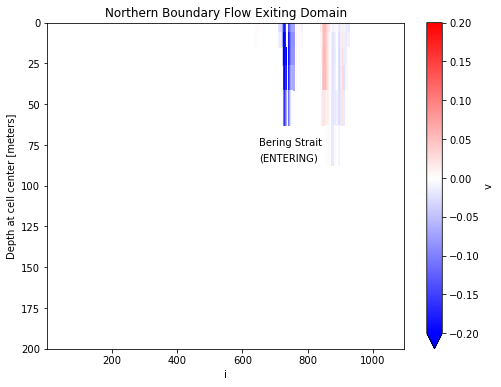

In [55]:
fig=ds_uv_north.v.isel(time=2).plot(figsize=[8, 6], yincrease=False, vmin=-.2,vmax=.2 ,cmap='bwr')
plt.ylim(200,0)
txt=plt.title('Northern Boundary Flow Exiting Domain')
txt=plt.text(650,75,'Bering Strait')
txt=plt.text(650,85,'(ENTERING)')

Text(0.5, 1.0, 'Northern Boundary temperature')

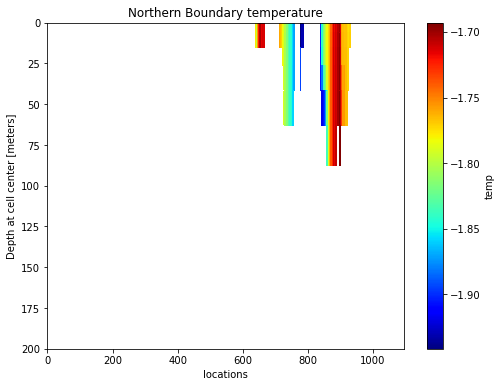

In [27]:
fig=ds_tr_north.temp.isel(time=2).plot(figsize=[8, 6], yincrease=False, cmap='jet')
plt.ylim(200,0)
plt.title('Northern Boundary temperature')

### Step 8: Finally some reformatting for MOM6

In [56]:
params=[]
params.append({'suffix':'_segment_001','dim0':2,'tr_in':'tracers_north.nc','tr_out':'obc_ts_north.nc','uv_in':'uv_north.nc','uv_out':'obc_uv_north.nc','ssh_in':'ssh_north.nc','ssh_out':'obc_ssh_north.nc'})
params.append({'suffix':'_segment_002','dim0':3,'tr_in':'tracers_west.nc','tr_out':'obc_ts_west.nc','uv_in':'uv_west.nc','uv_out':'obc_uv_west.nc','ssh_in':'ssh_west.nc','ssh_out':'obc_ssh_west.nc'})
params.append({'suffix':'_segment_003','dim0':2,'tr_in':'tracers_south.nc','tr_out':'obc_ts_south.nc','uv_in':'uv_south.nc','uv_out':'obc_uv_south.nc','ssh_in':'ssh_south.nc','ssh_out':'obc_ssh_south.nc'})

for pr in params:
    ds=xr.open_dataset(pr['tr_in'],decode_times=False)
    zl=ds.temp.z_l
    zi=0.5*(np.roll(zl,shift=-1)+zl)
    zi[-1]=6500.
    ds['z_i']=zi
    dz=zi-np.roll(zi,shift=1)
    dz[0]=zi[0]
    ds['dz']=dz
    nt=ds.time.shape[0]
    nx=ds.lon.shape[0]
    dz=np.tile(ds.dz.data[np.newaxis,:,np.newaxis],(nt,1,nx))
    da_dz=xr.DataArray(dz,coords=[('time',ds.time),('z_l',ds.z_l),('locations',ds.locations)])
    da_dz=da_dz.expand_dims('dim_0',pr['dim0'])
    ds.time.attrs['modulo']=' '
    da_temp=xr.DataArray(ds.temp.ffill(dim='locations',limit=None).ffill(dim='z_l').fillna(0.))
    da_temp=da_temp.expand_dims('dim_0',pr['dim0'])
    da_salt=xr.DataArray(ds.salt.ffill(dim='locations',limit=None).ffill(dim='z_l').fillna(0.))
    da_salt=da_salt.expand_dims('dim_0',pr['dim0'])
    ds_=xr.Dataset({'temp'+pr['suffix']:da_temp,'salt'+pr['suffix']:da_salt,'lon':ds.lon,'lat':ds.lat,'dz_temp'+pr['suffix']:da_dz,'dz_salt'+pr['suffix']:da_dz})
    for v in ds_:
        ds_[v].encoding['_FillValue']=1.e20    
    ds_.to_netcdf(pr['tr_out'],unlimited_dims=('time'))
    ds=xr.open_dataset(pr['uv_in'],decode_times=False)
    ds.time.attrs['modulo']=' '
    da_u=xr.DataArray(ds.u.ffill(dim='i',limit=None).ffill(dim='z_l').fillna(0.))
    da_u=da_u.expand_dims('dim_0',pr['dim0'])
    da_v=xr.DataArray(ds.v.ffill(dim='i',limit=None).ffill(dim='z_l').fillna(0.))
    da_v=da_v.expand_dims('dim_0',pr['dim0'])
    ds_=xr.Dataset({'u'+pr['suffix']:da_u,'v'+pr['suffix']:da_v,'lon':ds.lon,'lat':ds.lat,'dz_u'+pr['suffix']:da_dz,'dz_v'+pr['suffix']:da_dz})
    for v in ds_:
        ds_[v].encoding['_FillValue']=1.e20    
    ds_.to_netcdf(pr['uv_out'],unlimited_dims=('time'))
    ds=xr.open_dataset(pr['ssh_in'],decode_times=False)
    ds.time.attrs['modulo']=' '
    da_ssh=xr.DataArray(ds.ssh.ffill(dim='locations',limit=None).fillna(0.))
    da_ssh=da_ssh.expand_dims('dim_0',pr['dim0']-1)
    ds_=xr.Dataset({'ssh'+pr['suffix']:da_ssh,'lon':ds.lon,'lat':ds.lat})
    for v in ds_:
        ds_[v].encoding['_FillValue']=1.e20    
    ds_.to_netcdf(pr['ssh_out'],unlimited_dims=('time'))